In [1]:
# Get ELENA
!git clone https://github.com/michelelucente/ELENA.git
%cd ELENA

# Install Python deps for notebooks + examples
# (names follow ELENA’s README; CosmoTransitions is on PyPI)
%pip install -q numpy scipy matplotlib cosmoTransitions NatPy la-forge


Cloning into 'ELENA'...
remote: Enumerating objects: 621, done.
remote: Counting objects: 100% (228/228), done.
remote: Compressing objects: 100% (134/134), done.
remote: Total 621 (delta 166), reused 143 (delta 89), pack-reused 393 (from 1)
Receiving objects: 100% (621/621), 30.17 MiB | 17.22 MiB/s, done.
Resolving deltas: 100% (424/424), done.
/content/ELENA
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 1.7 MB/s eta 0:00:00


In [2]:
# Add ELENA/src to the Python path for imports (as suggested by the repo)
import sys, os
sys.path.append(os.path.abspath('src'))

In [3]:
%%writefile /content/utils.py
import numpy as np

# Simple energy unit conversion dictionary
convert_units = {
    "MeV": 1e-3,  # MeV → GeV
    "GeV": 1.0,   # base unit
    "TeV": 1e3,   # TeV → GeV
}

# Entropy density of the SM plasma (approximate, constant g_star)
g_star_SM = 106.75

def s_SM(T):
    """
    Standard Model entropy density s(T) ≈ (2π^2/45) g_* T^3
    T in the same energy units as the rest of the code (typically GeV).
    """
    T = np.asarray(T, dtype=float)
    return (2.0 * np.pi**2 / 45.0) * g_star_SM * T**3


Writing /content/utils.py


In [4]:
%%writefile /content/ELENA/src/utils.py
import numpy as np

# Simple energy unit conversion dictionary
convert_units = {
    "MeV": 1e-3,  # MeV → GeV
    "GeV": 1.0,   # base unit
    "TeV": 1e3,   # TeV → GeV
}

g_star_SM = 106.75

def s_SM(T):
    """
    Standard Model entropy density s(T) ≈ (2π^2/45) g_* T^3
    T in the same energy units as the rest of the code (typically GeV).
    """
    T = np.asarray(T, dtype=float)
    return (2.0 * np.pi**2 / 45.0) * g_star_SM * T**3


Overwriting /content/ELENA/src/utils.py


In [5]:
%%writefile four_d_full.py
"""
veff_4d_full.py
4D one-loop finite-T potential in high-T expansion up to m^4 log
+ daisy (ring) resummation for bosonic zero modes.

Landau gauge. Abelian Higgs: (H,G) + U(1) gauge (T,L).
"""

import numpy as np

# --------- default 4D inputs (you can overwrite from outside) ----------
g4    = 0.54
lam4  = 1.65e-3
m0sq4 = -(130.0**2)
Yphi  = 1.0

# DOF split (more physical than n_A=3 lumped)
n_h = 1.0
n_G = 1.0
n_T = 2.0   # transverse gauge
n_L = 1.0   # longitudinal gauge

# MSbar constants in CW
c_s = 1.5
c_v = 5.0/6.0

# thermal constant in HT log term: a_b = 16π^2 exp(3/2 - 2γ_E)
a_b = 16.0*np.pi**2 * np.exp(1.5 - 2.0*np.euler_gamma)

def _clip_pos(x, floor=1e-30):
    x = np.asarray(x, dtype=float)
    return np.maximum(x, floor)

def _m_abs(m2):
    # keep potential real for tachyonic regions (same spirit as your DR code)
    return np.sqrt(np.abs(np.asarray(m2, dtype=float)))

# ---------- tree-level masses ----------
def m_h2(phi):
    return m0sq4 + 3.0*lam4*phi*phi

def m_G2(phi):
    return m0sq4 + 1.0*lam4*phi*phi

def m_A2(phi):
    return (g4*Yphi)**2 * phi*phi

# ---------- tree-level potential ----------
def V_tree(phi):
    return 0.5*m0sq4*phi*phi + 0.25*lam4*(phi**4)

# ---------- CW (T=0) one-loop ----------
def V_CW(m2, n, mu4, c):
    m2 = np.asarray(m2, dtype=float)
    mu4 = float(mu4)
    # use |m2| to stay real; log uses |m2|
    m2a = np.abs(m2)
    return n * (m2a*m2a) * (np.log(_clip_pos(m2a)/(mu4*mu4)) - c) / (64.0*np.pi**2)

# ---------- high-T thermal (to m^4 log) ----------
def V_T_HT(m2, n, T):
    """
    From J_b expansion:
    ΔV_T = n * [  m^2 T^2/24  -  m^3 T/(12π)  -  m^4/(64π^2) ln(m^2/(a_b T^2))  ]
    Drop φ-independent -π^2 T^4/90.
    """
    T = float(T)
    m2 = np.asarray(m2, dtype=float)
    m  = _m_abs(m2)
    term_T2 = (m2 * T*T) / 24.0
    term_T3 = -(m**3 * T) / (12.0*np.pi)
    term_T4log = -(m2*m2) * np.log(_clip_pos(np.abs(m2))/(a_b*T*T)) / (64.0*np.pi**2)
    return n * (term_T2 + term_T3 + term_T4log)

# ---------- daisy / ring resummation ----------
def thermal_masses(T):
    """
    LO thermal masses for Abelian Higgs (one complex scalar):
      Π_scalar ≈ (λ/3 + g^2 Y^2/4) T^2
      m_D^2 (U(1) Debye) ≈ (g^2 Y^2/3) T^2   (one complex scalar)
    """
    T = float(T)
    Pi_s = (lam4/3.0 + (g4*g4*Yphi*Yphi)/4.0) * T*T
    mD2  = ((g4*g4*Yphi*Yphi)/3.0) * T*T
    return Pi_s, mD2

def V_ring(phi, T):
    """
    Add ring correction for bosonic zero modes that get Π(T):
      -T/(12π) Σ [ (M^2)^{3/2} - (m^2)^{3/2} ]
    We apply to: Higgs, Goldstone, gauge-longitudinal.
    """
    T = float(T)
    phi = np.asarray(phi, dtype=float)

    Pi_s, mD2 = thermal_masses(T)

    mh2 = m_h2(phi); MG2 = m_G2(phi); mA2 = m_A2(phi)

    Mh = _m_abs(mh2 + Pi_s)
    MG = _m_abs(MG2 + Pi_s)
    ML = _m_abs(mA2 + mD2)

    mh = _m_abs(mh2)
    mG = _m_abs(MG2)
    mA = _m_abs(mA2)

    return -(T/(12.0*np.pi)) * (
        n_h*(Mh**3 - mh**3) +
        n_G*(MG**3 - mG**3) +
        n_L*(ML**3 - mA**3)
    )

def V(phi, T, mu4=None, include_CW=True, include_ring=True):
    """
    Full 4D potential (in the HT-expanded thermal part) with daisy.
    Default choice: mu4 = π T (common for HT comparisons).
    """
    phi = np.asarray(phi, dtype=float)
    T = float(T)
    if mu4 is None:
        mu4 = np.pi*T if T > 0 else 1.0

    V0 = V_tree(phi)

    mh2 = m_h2(phi); mG2 = m_G2(phi); mA2 = m_A2(phi)

    # thermal HT (split gauge into T and L)
    VT = (
        V_T_HT(mh2, n_h, T) +
        V_T_HT(mG2, n_G, T) +
        V_T_HT(mA2, n_T, T) +
        V_T_HT(mA2, n_L, T)
    )

    VCW = 0.0
    if include_CW:
        VCW = (
            V_CW(mh2, n_h, mu4, c_s) +
            V_CW(mG2, n_G, mu4, c_s) +
            V_CW(mA2, n_T+n_L, mu4, c_v)
        )

    VR = 0.0
    if include_ring and T > 0:
        VR = V_ring(phi, T)

    return V0 + VCW + VT + VR

def dV(phi, T):
    phi = np.asarray(phi, dtype=float)
    T = float(T)
    h = 1e-3*np.maximum(1.0, np.abs(phi)) + 1e-5
    return (V(phi+h, T) - V(phi-h, T)) / (2.0*h)


Writing four_d_full.py


In [6]:
%%writefile custom_model.py
from four_d_full import V as V_raw, dV as dV_raw

class CustomModel:
    """
    Minimal drop-in replacement for `model`:
    exposes DVtot and gradV, wrapping your custom V and dV.
    """
    def __init__(self, vev, lambda_, g, xstep, Tstep, units="MeV"):
        self.vev     = vev
        self.lambda_ = lambda_
        self.g       = g
        self.xstep   = xstep
        self.Tstep   = Tstep
        self.units   = units

        # If you want rescaling by units, do it here.
        # For now: just pass through to your potential.
        self.DVtot = lambda phi, T: V_raw(phi, T)
        self.gradV = lambda phi, T: dV_raw(phi, T)


Writing custom_model.py


In [7]:
import numpy as np
import sys

# Ensure custom_model is reloaded if it was previously imported
if 'custom_model' in sys.modules:
    del sys.modules['custom_model']

from utils import convert_units
from custom_model import CustomModel  # instead of `from model import model`

# You can still choose units randomly if you like
units = np.random.choice(list(convert_units.keys()))

# Parameters
lambda_ = 1.65e-3
g       = 0.54
vev, units = 500, "MeV"
description = "Fast"

# Construct "model" using your custom potential
dp = CustomModel(vev, lambda_, g,
                 xstep = vev * 1e-3,
                 Tstep = vev * 1e-3,
                 units = units)

V  = dp.DVtot   # this now points to your big V(phi,T)
dV = dp.gradV   # this now points to your big dV(phi,T)

print(f"lambda = {lambda_}")
print(f"g      = {g}")
print(f"vev    = {vev} {units}")


phi_test = 10.0
T_test   = 150.0
print("V(10, 150) =", V(phi_test, T_test))
print("dV(10, 150) =", dV(phi_test, T_test))

lambda = 0.00165
g      = 0.54
vev    = 500 MeV
V(10, 150) = -46384897.8559133
dV(10, 150) = -154397.06454416373


In [8]:
# Remove the old 4d_full.py file
import os
if os.path.exists('/content/ELENA/4d_full.py'):
    os.remove('/content/ELENA/4d_full.py')
    print('Removed /content/ELENA/4d_full.py')

In [9]:
import numpy as np
import temperatures as temp

def find_extrema_fast(V, dV_unused, T, Phimax=150, step=1, *, max_expand=10, Phimax_cap=2e4):
    T = float(T)
    if T < 0:
        return [], [], []

    Phimax = float(Phimax)
    step   = float(step)

    # IMPORTANT: mimic ELENA -> start at phi=step (exclude phi=0)
    phi = np.arange(step, Phimax + step, step, dtype=float).reshape(-1, 1)
    v = np.asarray(V(phi, T), dtype=float).reshape(-1)

    argmaxV = np.argmax(v)
    expand_counter = 0
    while (argmaxV + 1) != len(v):
        if np.isnan(v[argmaxV]):
            return [], [], []
        expand_counter += 1
        if expand_counter > max_expand or Phimax >= Phimax_cap:
            break
        Phimax = min(Phimax_cap, 2.0 * Phimax)
        phi = np.arange(step, Phimax + step, step, dtype=float).reshape(-1, 1)
        v = np.asarray(V(phi, T), dtype=float).reshape(-1)
        argmaxV = np.argmax(v)

    if len(v) < 5 or not np.all(np.isfinite(v)):
        return [], [], []

    # Derivative from V-grid (uniform step)
    phi1 = phi.reshape(-1)
    dv = np.gradient(v, phi1)

    signs = np.sign(dv).reshape(-1)
    signs = np.round(signs).astype(int)

    sign_changes = np.diff(signs)  # negative: max, positive: min
    change_indices = np.nonzero(np.abs(sign_changes) == 2)[0]

    # Same "de-dup consecutive flips" logic as ELENA
    filtered = []
    previous = 0
    for idx in np.flip(change_indices):
        if idx != previous - 1:
            filtered.append(idx)
        previous = idx
    filtered = np.flip(np.array(filtered, dtype=int))

    loc, val, kind = [], [], []
    for idx in filtered:
        this_one = "max" if sign_changes[idx] < 0 else "min"

        dv_pair = dv[idx:idx+2]
        phi_pair = phi1[idx:idx+2]
        v_pair = v[idx:idx+2]

        # linear interpolate dv=0 crossing
        if this_one == "max":
            xz = np.interp(0.0, dv_pair[::-1], phi_pair[::-1])
        else:
            xz = np.interp(0.0, dv_pair, phi_pair)

        vz = np.interp(xz, phi_pair, v_pair)

        kind.append(this_one)
        loc.append(float(xz))
        val.append(float(vz))

    if len(kind) == 0:
        return [], [], []

    # sort by location
    order = np.argsort(loc)
    kind = (np.array(kind)[order]).tolist()
    loc  = (np.array(loc)[order]).tolist()
    val  = (np.array(val)[order]).tolist()

    # truncate after global minimum (same idea as ELENA)
    if len(kind) > 2:
        gmin = int(np.argmin(val))
        kind = kind[:gmin+1]
        loc  = loc[:gmin+1]
        val  = val[:gmin+1]

    return kind, loc, val

# patch
temp.find_extrema = find_extrema_fast

/usr/local/lib/python3.12/dist-packages/cosmoTransitions/finiteT.py:88: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  integrate.quad(f1, 0, abs(theta)**.5)[0]


In [10]:
import numpy as np

from temperatures import find_T_min, find_T_max, refine_Tmin
from four_d_full import V, dV   # your 3D potential + derivative

# --- user settings ---
vev   = 500.0
units = "MeV"

# IMPORTANT:
# ELENA's default in the class is tmax = 2.5*vev (see source),
# but if you expect a feature near ~1310 MeV and vev=500, you need tmax > 1310.
tmax = 3* vev   # e.g. 1600 MeV
T_step = 1e-2      # matches ELENA default style (step_phi = vev*T_step)

# -----------------------------
# ELENA-style temperature scan
# -----------------------------
T_max, vevs_max, max_min_vals, false_min_tmax = find_T_max(
    V, dV,
    precision=1e-2,
    Phimax=2*vev,
    step_phi=vev * T_step,
    tmax=tmax
)

T_min, vevs_min, false_min_tmin = find_T_min(
    V, dV,
    tmax=T_max,
    precision=1e-2,
    Phimax=2*vev,
    step_phi=vev * T_step,
    max_min_vals=max_min_vals
)

# maxvev selection (exact ELENA logic)
if T_max is not None and T_min is not None:
    maxvev = np.max(np.concatenate((vevs_max, vevs_min)))
elif T_max is not None:
    maxvev = np.max(vevs_max)
elif T_min is not None:
    maxvev = np.max(vevs_min)
else:
    maxvev = None

# refine Tmin (exact ELENA call)
T_min = refine_Tmin(T_min, V, dV, maxvev, log_10_precision=6) if T_min is not None else None

# -----------------------------
# Print results
# -----------------------------
print(f"T_max = {T_max:.6e} {units}" if T_max is not None else "T_max = None")
print(f"T_min = {T_min:.6e} {units}" if T_min is not None else "T_min = None")

if vevs_max is not None:
    print("vevs_max (sample):", vevs_max[:10])
if vevs_min is not None:
    print("vevs_min (sample):", vevs_min[:10])

/content/ELENA/four_d_full.py:72: RuntimeWarning: divide by zero encountered in divide
  term_T4log = -(m2*m2) * np.log(_clip_pos(np.abs(m2))/(a_b*T*T)) / (64.0*np.pi**2)


T_max = 7.403250e+02 MeV
T_min = 6.561680e+02 MeV
vevs_max (sample): [4162.74216316 4175.96084468 4178.1623196  4178.3384832  4178.38264437]
vevs_min (sample): [3936.32251706]


In [11]:
T_max, vevs_max, max_min_vals, false_min_tmax

(np.float64(740.3250000000002),
 array([4162.74216316, 4175.96084468, 4178.1623196 , 4178.3384832 ,
        4178.38264437]),
 [999.3989075131576, 4178.382644370516],
 [0, 0])

In [12]:
T_min, vevs_min, false_min_tmin

(np.float64(656.1679700517029), array([3936.32251706]), [0, 0])

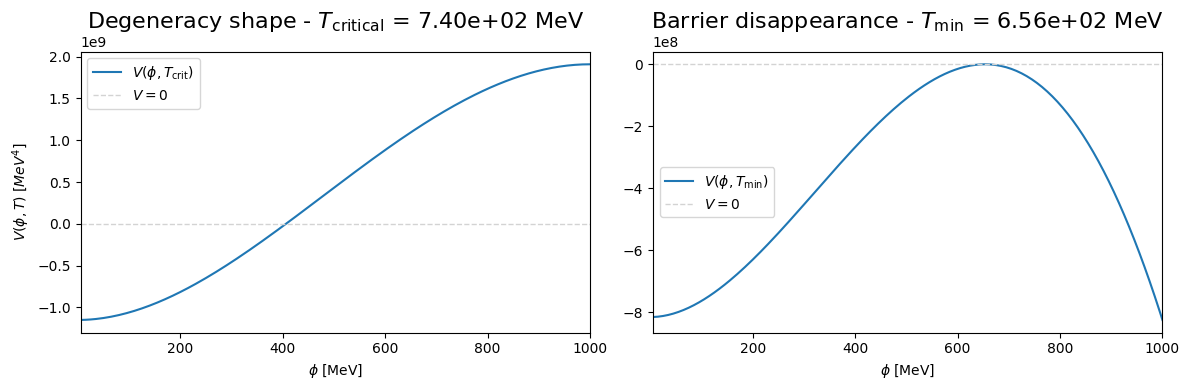

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# The `phi` variable was used in V() and for plot limits but was not defined in this scope.
# It should be defined with the same parameters used for T_max and T_min calculations.
# From cell F0dYI1eYByv_: Phimax=2*vev, step_phi=vev * T_step
_Phimax_for_plot = 2 * vev # vev is 500.0 from earlier cell
_T_step_for_calc = 1e-2 # T_step is 1e-2 from earlier cell
_step_phi_for_plot = vev * _T_step_for_calc # This will be 500 * 0.01 = 5.0

# Create the phi array
phi = np.arange(_step_phi_for_plot, _Phimax_for_plot + _step_phi_for_plot, _step_phi_for_plot)


if T_max is not None:
    v_max = V(phi, T_max)
if T_min is not None:
    v_min = V(phi, T_min)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

if T_max is not None:
    v_max = V(phi, T_max)
    # Changed label and title strings to raw strings (r"...") to avoid SyntaxWarning
    axes[0].plot(phi, v_max, label = r'$V(\phi, T_\mathrm{{crit}})$')
    axes[0].set_title(rf'Degeneracy shape - $T_\mathrm{{critical}}$ = {T_max:.2e} {units}',fontsize=16)
    axes[0].set_xlim(phi[0], phi[-1])
    # Changed ylabel string to raw string to avoid SyntaxWarning with \phi
    axes[0].set_ylabel(rf'$V(\phi, T)$ $[{units}^{4}]$')

if T_min is not None:
    v_min = V(phi, T_min)
    # Changed label and title strings to raw strings (r"...") to avoid SyntaxWarning
    axes[1].plot(phi, v_min, label= r'$V(\phi, T_\mathrm{{min}})$')
    axes[1].set_title(rf'Barrier disappearance - $T_\mathrm{{min}}$ = {T_min:.2e} {units}',fontsize=16)
    axes[1].set_xlim(phi[0], phi[-1])

for ax in axes:
    # Changed xlabel string to raw string to avoid SyntaxWarning with \phi
    ax.set_xlabel(rf'$\phi$ [{units}]')
    ax.axhline(false_min_tmax[1], color='lightgrey', linestyle='--', linewidth=1, label = "$V = 0$")
    ax.legend()

plt.tight_layout()
plt.show()

In [15]:
maxvev

np.float64(4178.382644370516)

In [16]:
import numpy as np
from espinosa import Vt_vec

def V_1d(phi, T):
    out = V(phi, T)
    a = np.asarray(out, dtype=float)
    return float(a) if a.ndim == 0 else a.reshape(-1)

def dV_1d(phi, T):
    out = dV(phi, T)
    a = np.asarray(out, dtype=float)
    return float(a) if a.ndim == 0 else a.reshape(-1)

true_vev = {}
false_vev = {}
S3overT = {}
V_min_value = {}
phi0_min = {}
V_exit = {}

def action_over_T(T, c_step_phi=1e-3, precision=1e-3):
    instance = Vt_vec(
        T, V_1d, dV_1d,
        step_phi=c_step_phi,
        precision=precision,
        vev0=maxvev,
        ratio_vev_step0=50
    )
    if instance.barrier:
        true_vev[T] = instance.true_min
        false_vev[T] = instance.phi_original_false_vev
        S3overT[T] = instance.action_over_T
        V_min_value[T] = instance.min_V
        phi0_min[T] = instance.phi0_min
        V_exit[T] = instance.V_exit
        return instance.action_over_T
    return None


In [17]:
import time

n_points = 100
temperatures = np.linspace(T_min, T_max, n_points)
action_vec = np.vectorize(action_over_T)

start_time = time.time()
action_vec(temperatures)
end_time = time.time()
print(f"Elapsed time: {end_time - start_time:.2f} seconds")

temperatures = temperatures = np.array(sorted(S3overT.keys()))

Elapsed time: 1.50 seconds


<>:19: SyntaxWarning: invalid escape sequence '\p'
<>:24: SyntaxWarning: invalid escape sequence '\p'
<>:29: SyntaxWarning: invalid escape sequence '\p'
<>:33: SyntaxWarning: invalid escape sequence '\m'
<>:33: SyntaxWarning: invalid escape sequence '\ '
<>:34: SyntaxWarning: invalid escape sequence '\p'
<>:38: SyntaxWarning: invalid escape sequence '\m'
<>:38: SyntaxWarning: invalid escape sequence '\ '
<>:39: SyntaxWarning: invalid escape sequence '\p'
<>:19: SyntaxWarning: invalid escape sequence '\p'
<>:24: SyntaxWarning: invalid escape sequence '\p'
<>:29: SyntaxWarning: invalid escape sequence '\p'
<>:33: SyntaxWarning: invalid escape sequence '\m'
<>:33: SyntaxWarning: invalid escape sequence '\ '
<>:34: SyntaxWarning: invalid escape sequence '\p'
<>:38: SyntaxWarning: invalid escape sequence '\m'
<>:38: SyntaxWarning: invalid escape sequence '\ '
<>:39: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipython-input-4058944208.py:19: SyntaxWarning: invalid escape sequence '\p'
 

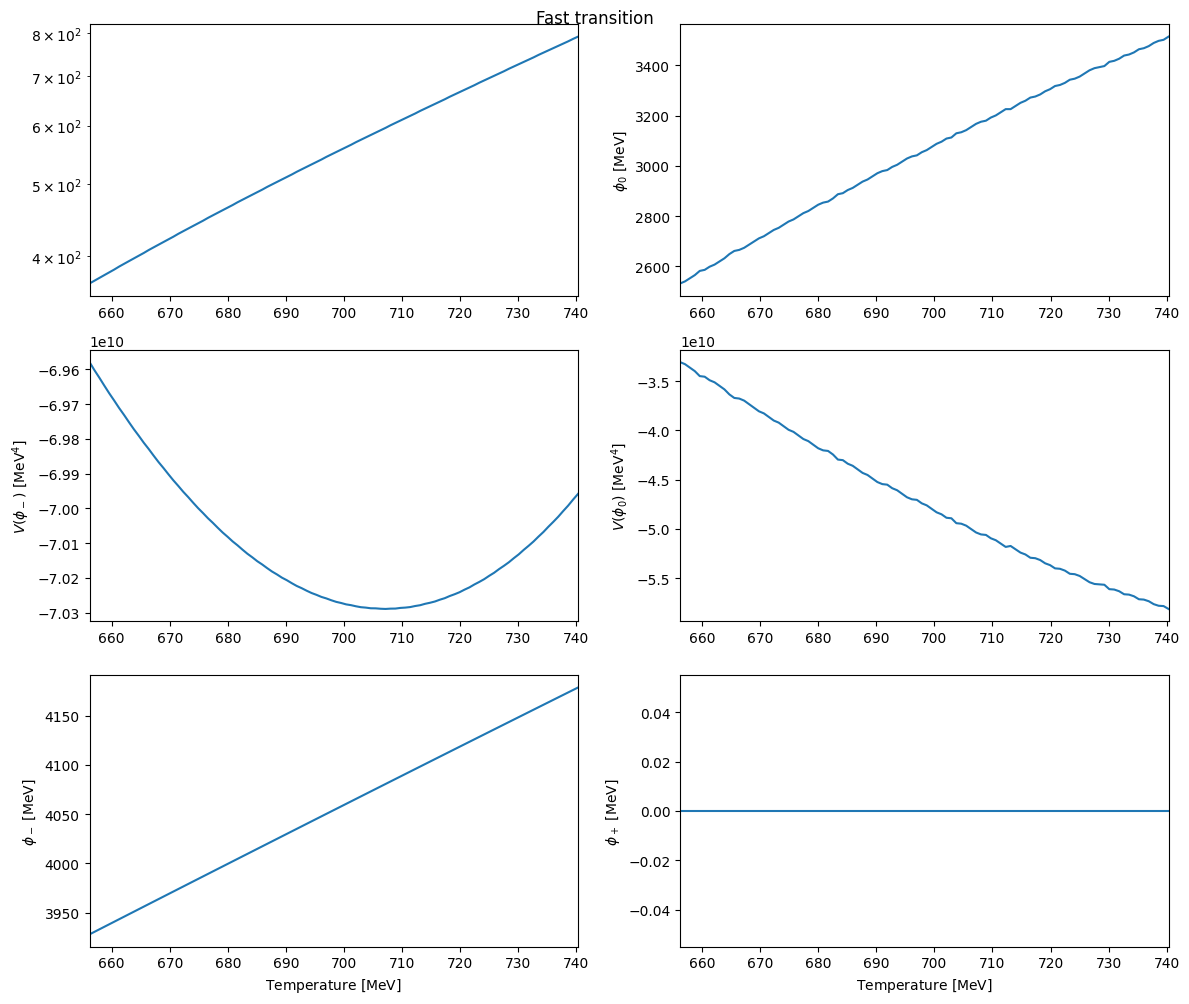

Minimum of the action at T = 6.56e+02 MeV


In [18]:
import matplotlib.pyplot as plt
from pathlib import Path

# Define the directory to save figures
figure_dir = "figures/"
Path(figure_dir).mkdir(parents=True, exist_ok=True)

fig, axes = plt.subplots(3, 2, figsize=(12, 10))

axes[0, 0].plot(temperatures, [S3overT[T] for T in temperatures])
#axes[0, 0].set_title('') # Corrected: removed stray ')
#axes[0, 0].set_xlabel(f"T [{units}]")
axes[0, 0].set_ylabel('') # Corrected: removed stray ')
axes[0, 0].set_yscale('log')

axes[0, 1].plot(temperatures, [phi0_min[T] for T in temperatures])
#axes[0, 1].set_title('') # Corrected: removed stray ')
#axes[0, 1].set_xlabel(f"T [{units}]")
axes[0, 1].set_ylabel(f"$\phi_0\ \mathrm{{[{units}]}}$")

axes[1, 0].plot(temperatures, [V_min_value[T] for T in temperatures])
#axes[1, 0].set_title('V(true_vev)')
#axes[1, 0].set_xlabel(f"T [{units}]")
axes[1, 0].set_ylabel(f"$V(\phi_-)\ \mathrm{{[{units}^4]}}$")

axes[1, 1].plot(temperatures, [V_exit[T] for T in temperatures])
#axes[1, 1].set_title('') # Corrected: removed stray ')
#axes[1, 1].set_xlabel(f"T [{units}]")
axes[1, 1].set_ylabel(f"$V(\phi_0)\ \mathrm{{[{units}^4]}}$")

axes[2, 0].plot(temperatures, [true_vev[T] for T in temperatures])
#axes[2, 0].set_title('True vev')
axes[2, 0].set_xlabel(f"$\mathrm{{Temperature\ [{units}]}}$")
axes[2, 0].set_ylabel(f"$\phi_-\ \mathrm{{[{units}]}}$")

axes[2, 1].plot(temperatures, [false_vev[T] for T in temperatures])
#axes[2, 1].set_title('False vev')
axes[2, 1].set_xlabel(f"$\mathrm{{Temperature\ [{units}]}}$")
axes[2, 1].set_ylabel(f"$\phi_+\ \mathrm{{[{units}]}}$")

for ax in axes.flatten():
    ax.set_xlim(temperatures[0], temperatures[-1])

plt.tight_layout()
fig.suptitle(f'{description} transition', y=1.00)
plt.savefig(figure_dir + f"action_{description}.pdf", dpi=300, bbox_inches='tight')
plt.show()

print(f"Minimum of the action at T = {temperatures[np.argmin([S3overT[T] for T in temperatures])]:.2e} {units}")

In [19]:
import importlib, inspect
import numpy as np
import temperatures as temp

# 1) reset the module (undo previous monkey patches)
temp = importlib.reload(temp)

# 2) patch s_SM so it accepts `units=` (only if the real one doesn't)
_sig = inspect.signature(temp.s_SM)
if "units" not in _sig.parameters:
    _real_s_SM = temp.s_SM
    def s_SM(T, units=None):
        return _real_s_SM(T)
    temp.s_SM = s_SM

def _asfloat(x):
    return float(np.asarray(x, dtype=float).squeeze())

# 3) safe compute_logP_f (forces scalars/1D everywhere)
def compute_logP_f_safe(m, V_min_value, S3overT, v_w, units='GeV', cum_method='cumulative_simpson'):
    # choose cumulative integrator
    if cum_method == 'cumulative_simpson' and hasattr(temp, "cumulative_simpson"):
        cum_f = temp.cumulative_simpson
    else:
        from scipy.integrate import cumulative_trapezoid
        cum_f = cumulative_trapezoid

    V = m.Vtot

    Temps = np.array(sorted(set(V_min_value.keys()) & set(S3overT.keys())), dtype=float)
    if Temps.size < 2:
        return np.array([]), Temps, np.array([]), np.array([]), np.array([])

    steps = len(Temps)
    T_step = max((Temps[-1] - Temps[0]) * 1e-3, 1e-6)

    def finite_dVdT(phi, T, step=T_step):
        Tm = max(T - step, 0.0)
        Tp = T + step
        if Tm == T:
            val = (V(np.array([phi]), Tp) - V(np.array([phi]), T)) / step
        else:
            val = (V(np.array([phi]), Tp) - V(np.array([phi]), Tm)) / (Tp - Tm)
        return _asfloat(val) - temp.s_SM(T, units=units)

    def finite_d2VdT2(phi, T):
        step2 = 0.5 * T_step
        Tm = max(T - step2, 0.0)
        Tp = T + step2
        if Tm == T:
            Tpp = T + 2 * step2
            f0 = finite_dVdT(phi, T,  step2)
            f1 = finite_dVdT(phi, Tp, step2)
            f2 = finite_dVdT(phi, Tpp, step2)
            return (f2 - 2*f1 + f0) / (step2**2)
        f_plus  = finite_dVdT(phi, Tp, step2)
        f_minus = finite_dVdT(phi, Tm, step2)
        return (f_plus - f_minus) / (Tp - Tm)

    e_vacuum = np.array([-_asfloat(V_min_value[t]) for t in Temps], dtype=float)
    e_radiation = np.pi**2 * temp.g_rho(Temps / temp.convert_units[units]) * Temps**4 / 30.0
    H = np.sqrt((e_vacuum + e_radiation) / 3.0) / (temp.M_pl * temp.convert_units[units])

    S3_T = np.array([_asfloat(S3overT[t]) for t in Temps], dtype=float)
    Gamma = Temps**4 * (S3_T / (2*np.pi))**(3/2) * np.exp(-S3_T)

    ratio_V = np.array([finite_d2VdT2(0.0, T) / finite_dVdT(0.0, T) for T in Temps], dtype=float)

    logP_f = np.zeros_like(Temps, dtype=float)
    f_ext = ratio_V * Gamma / H

    # integrate
    for i in range(steps - 1):
        cum_ratio_V = cum_f(ratio_V[i:], x=Temps[i:], initial=0.0)

        f1 = ratio_V[i:] / H[i:] * np.exp(cum_ratio_V / 3.0)
        cum_f1 = cum_f(f1, x=Temps[i:], initial=0.0)

        f2 = f_ext[i:] * np.exp(-cum_ratio_V) * (cum_f1**3)
        cum_f2 = cum_f(f2, x=Temps[i:], initial=0.0)

        logP_f[i] = - (4.0/243.0) * np.pi * (v_w**3) * cum_f2[-1]

    return logP_f, Temps, ratio_V, Gamma, H

temp.compute_logP_f = compute_logP_f_safe

print("Patched: temperatures.s_SM and temperatures.compute_logP_f (safe).")

Patched: temperatures.s_SM and temperatures.compute_logP_f (safe).


In [20]:
import numpy as np
from scipy.integrate import cumulative_trapezoid

import temperatures as temp
from dof_interpolation import g_rho
from utils import convert_units

def _crossing_linear(x, y, ystar):
    """
    Return x where y crosses ystar (linear interp). Assumes x increasing.
    Picks the first crossing from high-T side (largest x) going down in T if needed.
    """
    x = np.asarray(x, float)
    y = np.asarray(y, float)

    m = np.isfinite(x) & np.isfinite(y)
    x, y = x[m], y[m]
    if x.size < 2:
        return np.nan

    # find any sign change in (y-ystar)
    s = y - ystar
    idx = np.where(s[:-1] * s[1:] <= 0)[0]
    if idx.size == 0:
        return np.nan

    i = idx[0]
    x0, x1 = x[i], x[i+1]
    y0, y1 = y[i], y[i+1]
    if y1 == y0:
        return 0.5*(x0 + x1)
    return x0 + (ystar - y0) * (x1 - x0) / (y1 - y0)

def compute_logP_f_fixed(V_min_value, S3overT, *, v_w=1.0, units="MeV",
                         use_g_running=True, clip_exp=700.0):
    # Use only temps that exist in BOTH dicts
    Temps = np.array(sorted(set(V_min_value.keys()) & set(S3overT.keys())), dtype=float)
    if Temps.size < 3:
        raise RuntimeError("Need >=3 temperatures with both V_min_value and S3overT.")

    # Vacuum + radiation energy density -> H(T)
    e_vac = np.array([-V_min_value[T] for T in Temps], dtype=float)
    g = np.asarray(g_rho(Temps / convert_units[units]), dtype=float)
    e_rad = (np.pi**2 / 30.0) * g * Temps**4
    H = np.sqrt(np.maximum(e_vac + e_rad, 0.0) / 3.0) / (temp.M_pl * convert_units[units])

    # Nucleation rate prefactor
    S3_T = np.array([S3overT[T] for T in Temps], dtype=float)
    S3_clip = np.clip(S3_T, 0.0, clip_exp)  # stabilise exp(-S3/T)
    Gamma = Temps**4 * (np.maximum(S3_T, 0.0) / (2*np.pi))**1.5 * np.exp(-S3_clip)

    # ---- KEY FIX: ratio_V for radiation era (because your V dropped the constant T^4 term)
    if use_g_running:
        ln_g = np.log(np.maximum(g, 1e-300))
        dln_g_dT = np.gradient(ln_g, Temps)
        ratio_V = 3.0/Temps + dln_g_dT
    else:
        ratio_V = 3.0/Temps

    # Same structure as ELENA compute_logP_f
    logP_f = np.zeros_like(Temps)
    f_ext = ratio_V * Gamma / np.maximum(H, 1e-300)

    for i in range(len(Temps) - 1):
        Ts = Temps[i:]
        r  = ratio_V[i:]
        Hs = H[i:]
        fE = f_ext[i:]

        cum_r = cumulative_trapezoid(r, x=Ts, initial=0.0)

        f1 = r/np.maximum(Hs, 1e-300) * np.exp(cum_r/3.0)
        cum_f1 = cumulative_trapezoid(f1, x=Ts, initial=0.0)

        f2 = fE * np.exp(-cum_r) * cum_f1**3
        cum_f2 = cumulative_trapezoid(f2, x=Ts, initial=0.0)

        logP_f[i] = -(4.0/243.0) * np.pi * (v_w**3) * cum_f2[-1]

    return logP_f, Temps, ratio_V, Gamma, H

# ----------------------------
# RUN + milestones
# ----------------------------
logP_f, Temps, ratio_V, Gamma, H = compute_logP_f_fixed(
    V_min_value, S3overT, v_w=1.0, units=units, use_g_running=True
)

P_f = np.exp(np.clip(logP_f, -700.0, 0.0))  # physical volume fraction (0..1)
nH  = temp.N_bubblesH(Temps, Gamma, logP_f, H, ratio_V)

print(f"Temps range: {Temps[0]} → {Temps[-1]}   N={len(Temps)}")
print(f"ratio_V range: {np.nanmin(ratio_V)} → {np.nanmax(ratio_V)}")
print(f"logP_f range: {np.nanmin(logP_f)} → {np.nanmax(logP_f)}")
print(f"P_f range: {np.nanmin(P_f)} → {np.nanmax(P_f)}")
print(f"nH range: {np.nanmin(nH)} → {np.nanmax(nH)}")

T_nuc = _crossing_linear(Temps, nH, 1.0)
T_perc = _crossing_linear(Temps, P_f, 0.71)
T_completion = _crossing_linear(Temps, P_f, 0.01)

print(f"\nT_nuc = {T_nuc} {units}")
print(f"T_perc = {T_perc} {units}")
print(f"T_completion = {T_completion} {units}")

if np.isnan(T_nuc):
    print("Note: No nucleation found in this window (max(nH) < 1). Try extending the T scan.")
if np.isnan(T_perc):
    print("Note: P_f never reached 0.71 in this window.")
if np.isnan(T_completion):
    print("Note: P_f never reached 0.01 in this window.")

Temps range: 656.1679700517029 → 740.3250000000002   N=100
ratio_V range: 0.004053088189040294 → 0.00457289740983384
logP_f range: -1.717758958318192e-121 → 0.0
P_f range: 1.0 → 1.0
nH range: -0.0 → 7.8135184302764405e-112

T_nuc = nan MeV
T_perc = nan MeV
T_completion = nan MeV
Note: No nucleation found in this window (max(nH) < 1). Try extending the T scan.
Note: P_f never reached 0.71 in this window.
Note: P_f never reached 0.01 in this window.
